## Solving a inverse heat equation

We solve an inverse 2D heat equation and find the heat diffusion coefficent $D$.

In [1]:
import urllib
print('TorchPhysics Tutorial')
url = 'https://torchphysics.readthedocs.io/en/latest/tutorial/tutorial_start.html'
print(url)

TorchPhysics Tutorial
https://torchphysics.readthedocs.io/en/latest/tutorial/tutorial_start.html


In [2]:
import torch
import torchphysics as tp
import math


In [3]:
from IPython.display import display, Math, Latex
print(r'Underlying PDE for inverse problem')
display(Math(r'u_t(t,x) + D \cdot \Delta u(t,x) = 0\,, \quad x\in \Omega=[0,w]\times[0,h]\,, \
             \quad t \in [0,T]'))
print('Measurement data are given, the heat coefficient D should be calculated')

print('Feber report with basics and examples:')
url = 'https://inside-hosted-apps.bosch.com/FEBER/FeberApp/Pages/AMFile.aspx?Guid=4f66940a_de51_4187_9c26_90c21537b73f'
print(url)

Underlying PDE for inverse problem


<IPython.core.display.Math object>

Measurement data are given, the heat coefficient D should be calculated
Feber report with basics and examples:
https://inside-hosted-apps.bosch.com/FEBER/FeberApp/Pages/AMFile.aspx?Guid=4f66940a_de51_4187_9c26_90c21537b73f


Like always we first define the spaces. Even if we want to find the value of $D$ we still define a space for this coefficent.

In [4]:
X = tp.spaces.R2('x')
T = tp.spaces.R1('t')
D = tp.spaces.R1('D') # one dimensional parameter

U = tp.spaces.R1('u')

Next are the domains for space and time

In [5]:
w, h = 10, 10
t_0, t_end = 0, 10
temp_hot = 10

domain_x = tp.domains.Parallelogram(X, [0, 0], [w, 0], [0, h])
domain_t = tp.domains.Interval(T, t_0, t_end)

Now we construct the neural network like always, since we will not only find $D$ but also create an *interpolation* of the given data. 

For the parameter that we want to find, we use the class *Parameter*, which gets an inital guess and a spaces as an input. This parameter then has to be passed to the conditions, to be trained. 

In [6]:
# D NOT input of the model:
model = tp.models.FCN(input_space=X*T, output_space=U, hidden=(30,30,30))

param_D = tp.models.Parameter(init=0.0, space=D)

We need some data to use in the inverse problem, for this we create a solution with a FDM scheme.

In [7]:
import sys
sys.path.append('../..')

from fdm_heat_equation import FDM, transform_to_points

def inital_value(x):
    return temp_hot*torch.sin(math.pi/w*x[:,0])*torch.sin(math.pi/h*x[:,1])

final_D = 1.0 # the D value we want to find 
fdm_domain, fdm_time_domains, fdm_solution = FDM([0, w, 0, h], 2*[0.5], [t_0,t_end], [final_D], inital_value)
# transform to correct format for our use:
fdm_inp, fdm_out = transform_to_points(fdm_domain, fdm_time_domains, fdm_solution, [final_D], False)

Now we have around 40.000 data points. But we only want to use a few, so we use random.choice to pick here Npoints=500,2000,5000 points

In [8]:
import numpy as np
Npoints = 250
index = np.random.choice(len(fdm_inp), Npoints, replace=False) 
fdm_inp = fdm_inp[index, ]
fdm_out = fdm_out[index, ]

This data we use now to create a data condition that will train the network:

In [9]:
data_loader = tp.utils.PointsDataLoader((fdm_inp, fdm_out), batch_size = Npoints) # 500, 1000, 5000
data_condition = tp.conditions.DataCondition(module=model,
                                             dataloader=data_loader,
                                             norm=2, 
                                             use_full_dataset=True) 

To learn the parameter we have to use the PDE itself. Therefore we will create, just like in the forward problem, a condition for the PDE. For this condition we have to pass in the parameter $D$ we created.

In [10]:
# with static sampling points
# inner_sampler = tp.samplers.RandomUniformSampler(domain_x*domain_t, n_points=Npoints).make_static() 
#
# with dynamics sampling points
inner_sampler = tp.samplers.RandomUniformSampler(domain_x*domain_t, n_points = Npoints) # 500,1000, 5000

def heat_residual(u, x, t, D):
    return D*tp.utils.laplacian(u, x) - tp.utils.grad(u, t)

pde_condition = tp.conditions.PINNCondition(module=model,
                                            sampler=inner_sampler,
                                            residual_fn=heat_residual,
                                            name='pde_condition', 
                                            parameter=param_D) # here pass in the param

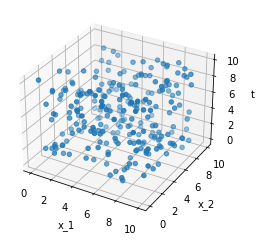

In [11]:
fig=tp.utils.scatter(X*T, inner_sampler)

This is all we have to do, to define the inverse problem. Now we can already start the training like always and the parameter $D$ will be learned too. 

In [12]:
opt_setting = tp.solver.OptimizerSetting(torch.optim.AdamW, lr=1e-2)
solver = tp.solver.Solver([pde_condition, data_condition], optimizer_setting = opt_setting)

import pytorch_lightning as pl

trainer = pl.Trainer(gpus=0,
                     max_steps=1000,
                     #logger=False, #False = tensorboard logs off
                     benchmark=True,
                     enable_checkpointing=False)
                     
trainer.fit(solver)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 2.0 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\daten\Pytorch\_venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\daten\Pytorch\_venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Finally we can have a look on the value of D. Which is pretty close to $D=1.0$, that we used in FDM to create the data.

In [13]:
param_D

Parameter:
{'D': tensor([[0.9732]], grad_fn=<AliasBackward0>)}

And the neural network learned the solution $u(x, t)$:

C:\daten\Pytorch\_venv\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
C:\daten\Pytorch\_venv\lib\site-packages\torchphysics\problem\domains\domain2D\parallelogram.py:134: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2318.)
  bary_coords = torch.stack(torch.meshgrid((x, y))).T.reshape(-1, 2)
C:\daten\Pytorch\_venv\lib\site-packages\torchphysics\utils\plotting\plot_functions.py:401: UserWarning: Creating a tensor from a list of numpy.ndarrays i

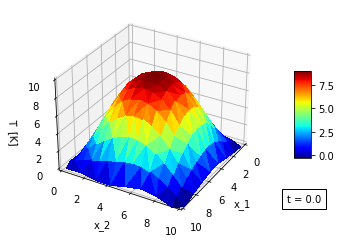

In [14]:
plot_sampler = tp.samplers.PlotSampler(plot_domain=domain_x, n_points=200,
                                       data_for_other_variables={'t': 0.0 })
fig = tp.utils.plot(model, lambda u : u, plot_sampler)
import matplotlib.pyplot as plt

ax = fig.gca(projection='3d')
ax.set(xlim=(0, w), ylim=(0, h), zlim = (0,temp_hot))
ax.set_zlabel('T  [K]')
plt.savefig('IHDE.png', dvi=600)

tensor(1.3508, grad_fn=<UnbindBackward0>)
tensor(-0.8042, grad_fn=<UnbindBackward0>)


C:\Users\gea3si\AppData\Local\Temp\ipykernel_19116\3860495763.py:24: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dvi" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('HDE_static_Tmaxmin.png', dvi = 600)


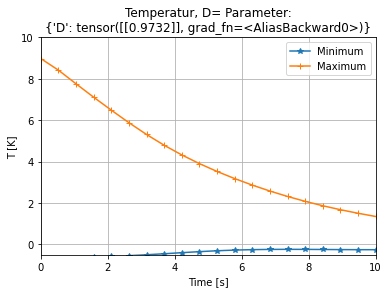

In [15]:
grid_sampler = tp.samplers.GridSampler(domain_x, n_points=128*128)
grid_points = grid_sampler.sample_points()

time_steps = 20
time_points = torch.linspace(0, t_end, time_steps)
min_max_tensor = torch.zeros((time_steps, 2))

for i in range(time_steps):
    time_tensor = time_points[i] * torch.ones((len(grid_points), 1))
    eval_points = grid_points.join(tp.spaces.Points.from_coordinates({'t': time_tensor}))
    model_out = model(eval_points)
    min_max_tensor[i, 0] = torch.min(model_out)
    min_max_tensor[i, 1] = torch.max(model_out)

import matplotlib.pyplot as plt
plt.plot(time_points, min_max_tensor[:, 0].detach().numpy(), marker='*')
plt.plot(time_points, min_max_tensor[:, 1].detach().numpy(), marker='+')
plt.legend(['Minimum', 'Maximum'])
plt.title('Temperatur, D= ' + str(param_D))
plt.grid()
plt.xlabel('Time [s]')
plt.ylabel('T [K]')
plt.axis([0,t_end,-0.5,temp_hot])
plt.savefig('HDE_static_Tmaxmin.png', dvi = 600)

print(min(min_max_tensor[:,1]))
print(min(min_max_tensor[:,0]))
